In [1]:
import numpy as np
import pandas as pd
import glob
import random

# image
from PIL import Image

# visu
import matplotlib.pyplot as plt

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

In [2]:
BATCH_SIZE = 64
IMG_WIDTH  = int(224/4)
IMG_HEIGHT = int(224/4)
MAX_EPOCHS = 1000

VGG_BATCH_SIZE = 16
VGG_IMG_WIDTH  = 224
VGG_IMG_HEIGHT = 224
VGG_MAX_EPOCHS = 100

In [3]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, zoom_range=(0.8, 1.2))

train_generator = datagen.flow_from_directory('./input/train',
                                                      batch_size=BATCH_SIZE,
                                                      target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                      class_mode='categorical')

validation_generator = datagen.flow_from_directory('./input/valid',
                                                           batch_size=BATCH_SIZE,
                                                           target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                           class_mode='categorical')

test_generator = datagen.flow_from_directory('./input/test',
                                                           batch_size=BATCH_SIZE,
                                                           target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                           class_mode='categorical')

Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


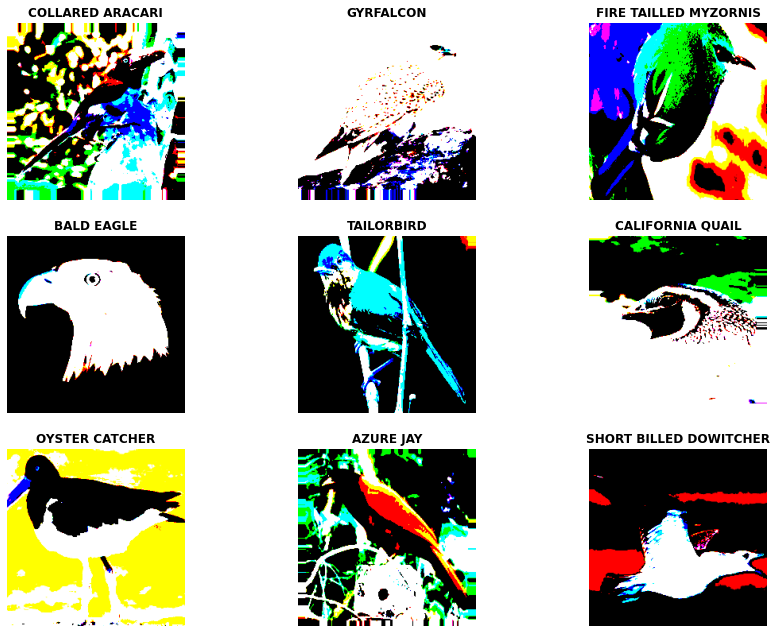

In [4]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for row in range(0, 3):
    for col in range(0, 3):
        image, label = train_generator.next()
        label_id = list(label[0]).index(1)
        label_str = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(label_id)]
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title(label_str, fontdict={"fontweight": 700})
        ax.imshow(image[0]);

In [5]:
def makeMyModel(name):
    model = Sequential(name=name)
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(400, activation='softmax'))

    return model

In [6]:
model = makeMyModel("BirdsBase")
model.summary()

Model: "BirdsBase"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0 

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics="accuracy")

In [8]:
callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]
#
history_baseline = model.fit(train_generator,
                                      batch_size=BATCH_SIZE,
                                      epochs=MAX_EPOCHS,
                                      validation_data=validation_generator,
                                      callbacks=callback)

model.save(f"{model.name}.h5")


Epoch 1/1000
3517/3650 [===========================>..] - ETA: 16s - loss: 6.0322 - accuracy: 0.0037

KeyboardInterrupt: 

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
plot_history(history_baseline, title='', axs=None, exp_name="");


In [ ]:
model.evaluate(test_generator, verbose=0)

In [ ]:
model_VGG = VGG16(include_top=False, weights='imagenet', input_shape=(VGG_IMG_WIDTH, VGG_IMG_HEIGHT, 3))
model_VGG.summary()

In [ ]:
model_VGG.trainable = False
model_VGG.summary()

In [ ]:
flattening_layer = layers.Flatten()
dropout = layers.Dropout(rate=0.4)
norm = layers.BatchNormalization()
last_layer = layers.Dense(400, activation='softmax')

model_VGG = Sequential([model_VGG, flattening_layer, dropout, norm, last_layer])

model_VGG.summary()

In [ ]:
model_VGG.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics="accuracy")

In [ ]:
train_generator = datagen.flow_from_directory('./input/train',
                                                      batch_size=VGG_BATCH_SIZE,
                                                      target_size=(VGG_IMG_WIDTH, VGG_IMG_HEIGHT),
                                                      class_mode='categorical')

validation_generator = datagen.flow_from_directory('./input/valid',
                                                           batch_size=VGG_BATCH_SIZE,
                                                           target_size=(VGG_IMG_WIDTH, VGG_IMG_HEIGHT),
                                                           class_mode='categorical')

test_generator = datagen.flow_from_directory('./input/test',
                                                           batch_size=VGG_BATCH_SIZE,
                                                           target_size=(VGG_IMG_WIDTH, VGG_IMG_HEIGHT),
                                                           class_mode='categorical')

In [ ]:
callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]

history_VGG = model_VGG.fit(train_generator,
                            epochs=VGG_MAX_EPOCHS,
                            validation_data=validation_generator,
                            callbacks=callback)

In [ ]:
model_VGG.save("model_VGG.h5")